# Library

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix

# Set torch constant

In [2]:
# CUDA Check
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Set dtype
dtype = torch.double

# Load data and check the data

In [3]:
mnist_train = datasets.MNIST(
    root="data/",
    train=True,
    transform=transforms.ToTensor(),
    download=True)

mnist_test = datasets.MNIST(
    root="data/",
    train=False,
    transform=transforms.ToTensor(),
    download=True)

print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()


Original train example # 33023
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,  

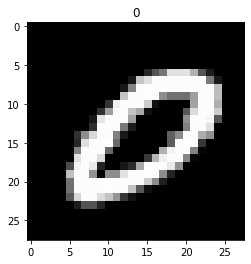

In [4]:
# Rename the data and labels
X_train = mnist_train.data
y_train = mnist_train.targets
X_test = mnist_test.data
y_test = mnist_test.targets

# Data check
idx = np.random.randint(0, X_train.shape[0])

print("Original train example # " + str(idx))
print(X_train[idx])

plt.figure()
plt.imshow(X_train[idx], cmap='gray')
plt.title(y_train[idx].item())
plt.show()

# Make custom dataloader

In [5]:
# Check a example's shape
shape = X_train.shape[1:]
print("Data shape : ", shape)

# Calculate vector size from shape
def calculate_vector_size(shape):
    v = 1
    for s in shape:
        v *= s
    return v

# Construct custom dataloader for train
class MNIST_Dataset(torch.utils.data.Dataset):
    # Initialize and preprocess the data
    def __init__(self, is_train):
        # MNIST data convert to cuda tensor and change the data type
        if is_train:
            X = X_train.to(dtype=dtype, device=device)
            y = y_train.to(device=device)
        else:
            X = X_test.to(dtype=dtype, device=device)
            y = y_test.to(device=device)
        
        # Normalize
        X = self._normalize(X, 0, 255)
        
        # Reshape
        vector_size = calculate_vector_size(X_train.shape[1:])
        X = self._reshape(X, vector_size)
        
        # Move to the class object
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def _normalize(self, data, min_value, max_value):
        return (data - min_value) / (max_value - min_value)
    
    def _reshape(self, data, vector_size):
        return data.view(-1, vector_size)
    

Data shape :  torch.Size([28, 28])


# Set hyperparameters

In [6]:
# Hyperparameters
learning_rate = 0.1
training_epochs = 100
display_step = 10

batch_size = 100

D_in = calculate_vector_size(shape)
H = 512
D_out = 10

# Make batch with dataloader

batch train data example shape :  torch.Size([100, 784])
batch test data example shape :  torch.Size([100, 784])


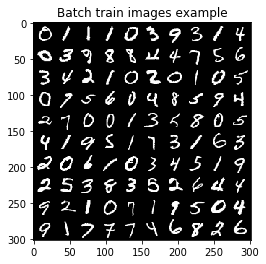

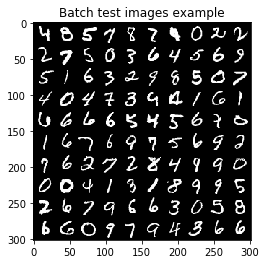

In [7]:
# Show image of batch data
def show_grid_image(img, title):
    n_img = img.shape[0]
    img = utils.make_grid(img.cpu().detach(), nrow = int(np.ceil(np.sqrt(n_img))))
    
    np_img = img.numpy()
    
    plt.figure()
    plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

# Instantiate datalodaer
train_data_loader = torch.utils.data.DataLoader(MNIST_Dataset(is_train=True), batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(MNIST_Dataset(is_train=False), batch_size, shuffle=True)

# Extract batch examples
batch_train_data_example, batch_train_label_example = next(iter(train_data_loader))
batch_test_data_example, batch_test_label_example = next(iter(test_data_loader))
print("batch train data example shape : ", batch_train_data_example.shape)
print("batch test data example shape : ", batch_test_data_example.shape)

# Current batch dimension (100, 784) -> batch dimension to show image (100, 1, 28, 28)
show_grid_image(batch_train_data_example.reshape(batch_size, 1, 28, 28), "Batch train images example")
show_grid_image(batch_test_data_example.reshape(batch_size, 1, 28, 28), "Batch test images example")

In [8]:
# Convert to cuda tensor and reshape the whole data
X_train = X_train.to(dtype=dtype, device=device).view(X_train.shape[0], D_in)
y_train = y_train.to(device=device)
X_test = X_test.to(dtype=dtype, device=device).view(X_test.shape[0], D_in)
y_test = y_test.to(device=device)

# Construct the model

In [9]:
# Initialize model parameters
def initialize_parameters(model):
    for p in model.parameters():
        if (p.dim() > 1):
            torch.nn.init.xavier_normal_(p)
        else:
            torch.nn.init.uniform_(p, 0.1, 0.2)

# Design the model
class MLP(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=D_in, out_features=H)
        self.activation = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(in_features=H, out_features=D_out)
        
    def forward(self, x):
        output = self.linear1(x)
        output = self.activation(output)
        output = self.linear2(output)
        return output

# Construct the model, loss, optimizer
model = MLP(D_in, H, D_out).to(dtype=dtype, device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model

In [10]:
losses = []

model.train()
initialize_parameters(model)

print("Training...")

for epoch in range(training_epochs):
    avg_loss = 0
    
    for data in train_data_loader:
        # Extract the data
        images, labels = data
        
        # Initialize optimizer
        optimizer.zero_grad()
        
        # Calculate model outputs and loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.item() / labels.size(0)
        
        # Calculate loss and update weights
        loss.backward()
        optimizer.step()
    
    losses.append(avg_loss)
    
    if (epoch + 1) % display_step == 0:
        print("epoch " + str(epoch + 1) + " : ", losses[-1])
    
print("Finsh training")

Training...
epoch 10 :  0.671453225301558
epoch 20 :  0.33565934190231744
epoch 30 :  0.1995351882474737
epoch 40 :  0.12678147927766623
epoch 50 :  0.08538193977156545
epoch 60 :  0.06037335770663066
epoch 70 :  0.044581471135828256
epoch 80 :  0.03435324600167005
epoch 90 :  0.02741480777203225
epoch 100 :  0.022625967089773727
Finsh training


# Plot the train result

In [11]:
def plot_losses(losses):
    # Set figure and show the graph
    plt.figure()
    plt.plot(losses, label="loss")
    plt.legend()
    plt.show()

def show_accuracies(model, train_data_loader, test_data_loader):
    # We don't need to calculate the gradients
    with torch.no_grad():
        # Change the mode for model to evaluate
        model.eval()
    
        # Show train accuracy
        train_corrects = 0
        train_total = 0
    
        # If your graphic card can't afford to compute model at once, you can use the batch!
        for data in train_data_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, axis=1)
            train_total += labels.size(0)
            train_corrects += (labels == predictions).sum().item()
    
        print("Train accuracy : ", (train_corrects / train_total) * 100, "%")
    
        # Show test accuracy
        test_corrects = 0
        test_total = 0
    
        # If your graphic card can't afford to compute model at once, you can use the batch!
        for data in test_data_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, axis=1)
            test_total += labels.size(0)
            test_corrects += (labels == predictions).sum().item()
            
        print("Test accuracy : ", (test_corrects / test_total) * 100, "%")
    
def show_confusion_matrix(model, test_data_loader):
    # We don't need to calculate the gradients
    with torch.no_grad():
        # Change the mode for model to evaluate
        model.eval()
    
        # Show confusion matrix
        total_predictions = torch.empty(0).to(dtype=torch.long, device=device)
        total_labels = torch.empty(0).to(dtype=torch.long, device=device)
    
        for data in test_data_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, axis=1)
            total_predictions = torch.cat((predictions, total_predictions), axis=0)
            total_labels = torch.cat((labels, total_labels), axis=0)
        
        total_predictions_ = total_predictions.cpu().detach().numpy()
        total_labels_ = total_labels.cpu().detach().numpy()
    
        print("Confusion matrix \n", confusion_matrix(total_labels_, total_predictions_))

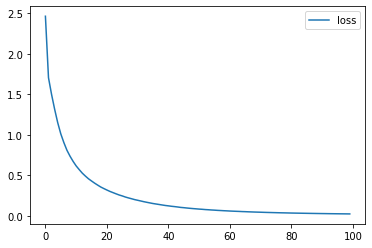

Train accuracy :  99.99833333333333 %
Test accuracy :  98.09 %
Confusion matrix 
 [[ 973    0    1    0    1    1    0    2    1    1]
 [   0 1124    3    2    0    1    2    1    2    0]
 [   4    1 1009    1    2    0    4    6    5    0]
 [   0    0    2  995    0    5    0    1    3    4]
 [   1    0    2    1  965    0    3    0    0   10]
 [   4    0    0    6    2  870    3    0    4    3]
 [   5    2    0    1    5    3  938    0    4    0]
 [   1    2    5    2    1    0    0 1007    5    5]
 [   2    2    5    3    3    4    2    3  947    3]
 [   1    2    0    6    8    2    0    6    3  981]]


In [12]:
# Plot losses
plot_losses(losses)

# Show accuracy
show_accuracies(model, train_data_loader, test_data_loader)

# Show confusion matrix
show_confusion_matrix(model, test_data_loader)

# Save the model parameters

In [13]:
# Save the model paramters
with torch.no_grad():
    # Print model's state dictionary
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
        
    # Print optimizer's state dictionary
    print("Optimizer's state_dict:")
    for var_name in optimizer.state_dict():
        print(var_name, "\t", optimizer.state_dict()[var_name])
    
    # Save the model parameters
    torch.save(model.state_dict(), "model.pt")

Model's state_dict:
linear1.weight 	 torch.Size([512, 784])
linear1.bias 	 torch.Size([512])
linear2.weight 	 torch.Size([10, 512])
linear2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [2710150193784, 2710629553000, 2710629552200, 2710629553080]}]


# Load the model parameters

In [14]:
# Not loaded model
model1 = MLP(D_in, H, D_out)
model1.to(dtype=dtype, device=device)
# loaded model
model2 = MLP(D_in, H, D_out)
model2.to(dtype=dtype, device=device)
# Load the model parameters
model2.load_state_dict(torch.load("model.pt"))

# Evaluate the results
# Evaluate the model1
print("Evaluate model1 (Not loaded model)")
show_accuracies(model1, train_data_loader, test_data_loader)
show_confusion_matrix(model1, test_data_loader)

# Evaluate the model2
print("Evaluate model2 (Loaded model)")
show_accuracies(model2, train_data_loader, test_data_loader)
show_confusion_matrix(model2, test_data_loader)

Evaluate model1 (Not loaded model)
Train accuracy :  8.275 %
Test accuracy :  7.449999999999999 %
Confusion matrix 
 [[ 216   62    0    9   39  404    0    2  248    0]
 [  83    5    0    0 1043    1    0    0    3    0]
 [ 157   19    0   15  430  307    0    2  101    1]
 [ 280   12    0    6  445  195    6    0   63    3]
 [  26   20    0    7  288  634    4    2    1    0]
 [ 243   48    0    7  264  208   18    6   87   11]
 [  91   20    0    8  286  520    0    7   26    0]
 [ 246   95    0    8   99  538    0   15   27    0]
 [ 285   44    0    5  407  213    2    7    7    4]
 [ 203   29    0    9  216  539    0    8    5    0]]
Evaluate model2 (Loaded model)
Train accuracy :  99.99833333333333 %
Test accuracy :  98.09 %
Confusion matrix 
 [[ 973    0    1    0    1    1    0    2    1    1]
 [   0 1124    3    2    0    1    2    1    2    0]
 [   4    1 1009    1    2    0    4    6    5    0]
 [   0    0    2  995    0    5    0    1    3    4]
 [   1    0    2    1  965 

# Make baseline model

In [15]:
# Hyperparameters
learning_rate = 0.1
training_epochs = 200
display_step = 20

batch_size = 100

D_in = calculate_vector_size(shape)
H1 = 1024
H2 = 512
D_out = 10

In [16]:
# Design the model
class MLP(torch.nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=D_in, out_features=H1)
        self.activation1 = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(in_features=H1, out_features=H2)
        self.activation2 = torch.nn.Tanh()
        self.linear3= torch.nn.Linear(in_features=H2, out_features=D_out)
        
    def forward(self, x):
        self.h1 = self.linear1(x)
        self.a1 = self.activation1(self.h1)
        self.h2 = self.linear2(self.a1)
        self.a2 = self.activation2(self.h2)
        output = self.linear3(self.a2)
        return output
    
    def get_inner_results(self):
        return self.h1, self.a1, self.h2, self.a2

# Construct the model, loss, optimizer
model = MLP(D_in, H1, H2, D_out).to(dtype=dtype, device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model

In [17]:
losses = []

model.train()
initialize_parameters(model)

print("Training...")

for epoch in range(training_epochs):
    avg_loss = 0
    
    for data in train_data_loader:
        # Extract the data
        images, labels = data
        
        # Initialize optimizer
        optimizer.zero_grad()
        
        # Calculate model outputs and loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.item() / labels.size(0)
        
        # Calculate loss and update weights
        loss.backward()
        optimizer.step()
    
    losses.append(avg_loss)
    
    if (epoch + 1) % display_step == 0:
        print("epoch " + str(epoch + 1) + " : ", losses[-1])
    
print("Finsh training")

# Save the model parameters
torch.save(model.state_dict(), "mlp.pt")

Training...
epoch 20 :  0.13373068836737526
epoch 40 :  0.0300298360176155
epoch 60 :  0.013155736379292274
epoch 80 :  0.008038021183100968
epoch 100 :  0.005625416306160209
epoch 120 :  0.004296151706545538
epoch 140 :  0.0034322426395336945
epoch 160 :  0.0028423227390321454
epoch 180 :  0.0024186427402210623
epoch 200 :  0.0020964067539141723
Finsh training


# Train results

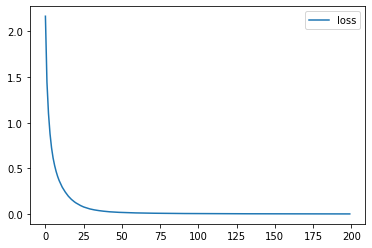

Train accuracy :  100.0 %
Test accuracy :  98.24000000000001 %
Confusion matrix 
 [[ 973    0    1    1    1    0    2    1    1    0]
 [   0 1125    2    2    0    1    2    1    2    0]
 [   4    1 1009    4    1    0    3    5    5    0]
 [   0    0    1  993    0    3    0    3    1    9]
 [   1    0    2    1  962    0    3    2    0   11]
 [   3    0    0    8    1  867    5    1    4    3]
 [   3    2    1    1    5    5  940    0    1    0]
 [   1    2    5    2    1    0    0 1010    2    5]
 [   2    0    2    2    2    4    0    2  956    4]
 [   1    2    0    2    8    1    0    6    0  989]]


In [18]:
# Plot losses
plot_losses(losses)

# Show accuracy
show_accuracies(model, train_data_loader, test_data_loader)

# Show confusion matrix
show_confusion_matrix(model, test_data_loader)

# Analyze model parameters

In [19]:
# Plot inner distribution
def plot_inner_dist(X, h1, a1, h2, a2):
    # Convert tensors to numpy objects
    X_ = X.cpu().detach().numpy()
    h1_ = h1.cpu().detach().numpy()
    a1_ = a1.cpu().detach().numpy()
    h2_ = h2.cpu().detach().numpy()
    a2_ = a2.cpu().detach().numpy()
    
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    ax[0, 0].hist(X_.reshape(-1))
    
    ax[1, 0].hist(h1_.reshape(-1))
    ax[1, 1].hist(a1_.reshape(-1))
    ax[1, 2].scatter(h1_[0], a1_[0]) # One example's result
    
    ax[2, 0].hist(h2_.reshape(-1))
    ax[2, 1].hist(a2_.reshape(-1))
    ax[2, 2].scatter(h2_[0], a2_[0]) # One example's result
    
    plt.show()

Each output's dimension
x's shape :  torch.Size([10000, 784])
h1's shape :  torch.Size([10000, 1024])
a1's shape :  torch.Size([10000, 1024])
h2's shape :  torch.Size([10000, 512])
a2's shape :  torch.Size([10000, 512])


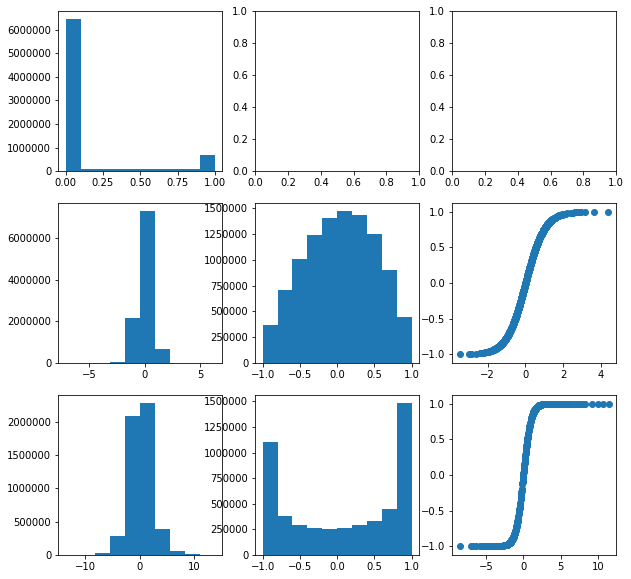

In [20]:
# Change the model to evaluation model
model.eval()

# Predict from the model
# Total data loader for test data
total_data_loader = torch.utils.data.DataLoader(MNIST_Dataset(is_train=False), y_test.size(0), shuffle=True)
# Calculate the model
for data in total_data_loader:
    images, _ = data
    y_pred = model(images)

# Get inner results from model
h1, a1, h2, a2 = model.get_inner_results()

# Check dimension of each output
print("Each output's dimension")
print("x's shape : ", images.shape)
print("h1's shape : ", h1.shape)
print("a1's shape : ", a1.shape)
print("h2's shape : ", h2.shape)
print("a2's shape : ", a2.shape)
    
plot_inner_dist(images, h1, a1, h2, a2)

# Add batch normalization to model

In [21]:
# Design the model
class MLPB(torch.nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLPB, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=D_in, out_features=H1)
        self.normalization1 = torch.nn.BatchNorm1d(num_features=H1)
        self.activation1 = torch.nn.Tanh()
        
        self.linear2 = torch.nn.Linear(in_features=H1, out_features=H2)
        self.normalization2 = torch.nn.BatchNorm1d(num_features=H2)
        self.activation2 = torch.nn.Tanh()
        
        self.linear3= torch.nn.Linear(in_features=H2, out_features=D_out)
        
    def forward(self, x):
        self.h1 = self.linear1(x)
        self.n1 = self.normalization1(self.h1)
        self.a1 = self.activation1(self.h1)
        
        self.h2 = self.linear2(self.a1)
        self.n2 = self.normalization2(self.h2)
        self.a2 = self.activation2(self.h2)
        
        output = self.linear3(self.a2)
        return output
    
    def get_inner_results(self):
        return self.h1, self.a1, self.h2, self.a2

# Construct the model, loss, optimizer
model = MLPB(D_in, H1, H2, D_out).to(dtype=dtype, device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model

In [22]:
losses = []

model.train()
initialize_parameters(model)

print("Training...")

for epoch in range(training_epochs):
    avg_loss = 0
    
    for data in train_data_loader:
        # Extract the data
        images, labels = data
        
        # Initialize optimizer
        optimizer.zero_grad()
        
        # Calculate model outputs and loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.item() / labels.size(0)
        
        # Calculate loss and update weights
        loss.backward()
        optimizer.step()
    
    losses.append(avg_loss)
    
    if (epoch + 1) % display_step == 0:
        print("epoch " + str(epoch + 1) + " : ", losses[-1])
    
print("Finsh training")

# Save the model parameters
torch.save(model.state_dict(), "mlp_with_batch.pt")

Training...
epoch 20 :  0.13249049482589495
epoch 40 :  0.029587599850614058
epoch 60 :  0.013018194316996082
epoch 80 :  0.007953249903401101
epoch 100 :  0.005594003039604463
epoch 120 :  0.0042549782949718494
epoch 140 :  0.0034096449311510537
epoch 160 :  0.0028261949218849865
epoch 180 :  0.002403340671806031
epoch 200 :  0.0020856762453869164
Finsh training


# Train results

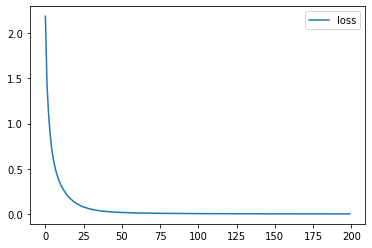

Train accuracy :  100.0 %
Test accuracy :  98.2 %
Confusion matrix 
 [[ 972    0    1    0    1    0    2    1    2    1]
 [   0 1126    2    2    0    1    2    1    1    0]
 [   5    1 1009    2    1    0    3    5    6    0]
 [   0    0    0  994    0    3    0    4    3    6]
 [   0    0    1    1  966    1    5    1    0    7]
 [   4    0    0    6    2  869    4    1    4    2]
 [   4    2    1    1    2    4  943    0    1    0]
 [   2    2    6    1    1    0    0 1008    4    4]
 [   3    0    3    3    3    6    1    3  949    3]
 [   1    2    0    5    7    1    1    8    0  984]]


In [23]:
# Plot losses
plot_losses(losses)

# Show accuracy
show_accuracies(model, train_data_loader, test_data_loader)

# Show confusion matrix
show_confusion_matrix(model, test_data_loader)

# Analyze model parameters

Each output's dimension
x's shape :  torch.Size([10000, 784])
h1's shape :  torch.Size([10000, 1024])
a1's shape :  torch.Size([10000, 1024])
h2's shape :  torch.Size([10000, 512])
a2's shape :  torch.Size([10000, 512])


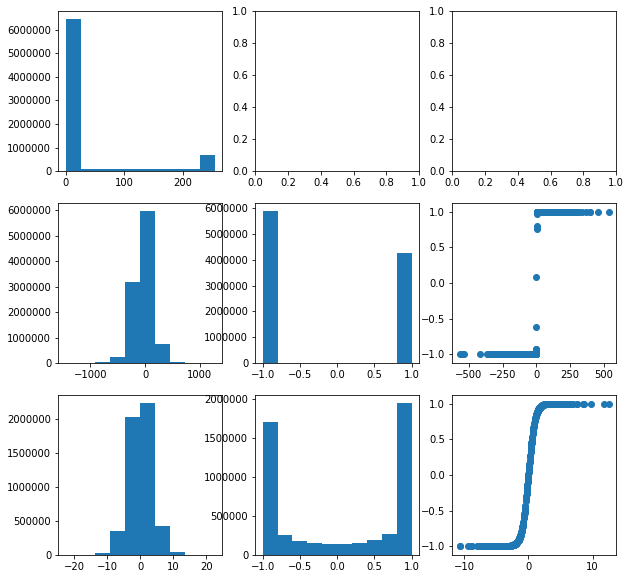

In [24]:
# Change the model to evaluation model
model.eval()

# Predict from the model
# Total data loader for test data
total_data_loader = torch.utils.data.DataLoader(MNIST_Dataset(is_train=False), y_test.size(0), shuffle=True)
# Calculate the model
for data in total_data_loader:
    images, _ = data
    y_pred = model(X_test)

# Get inner results from model
h1, a1, h2, a2 = model.get_inner_results()

# Check dimension of each output
print("Each output's dimension")
print("x's shape : ", images.shape)
print("h1's shape : ", h1.shape)
print("a1's shape : ", a1.shape)
print("h2's shape : ", h2.shape)
print("a2's shape : ", a2.shape)
    
plot_inner_dist(images, h1, a1, h2, a2)

# Batch normalization은 Internal Covariance Shift를 해결?

해결하지 않는다는 주장이 최근 논문에 등장! (더군다나 ICS를 해결하는 것이 성능 향상과 관련이 없다.)

"How Batch Normalization Help Optimization?" : 
https://arxiv.org/pdf/1805.11604.pdf


오히려 space smoothing을 통해 학습이 잘 진행되도록 하는 역할을 함
즉 충분히 복잡한 공간에 대해서 regularization 효과를 나타냄

# Add dropout to model

In [25]:
# Hyperparameters
learning_rate = 0.1
training_epochs = 200
display_step = 20

batch_size = 100
dropout_rate = 0.2

D_in = calculate_vector_size(shape)
H1 = 1024
H2 = 512
D_out = 10

In [26]:
# Design the model
class MLPD(torch.nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLPD, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=D_in, out_features=H1)
        self.dropout1 = torch.nn.Dropout(p=dropout_rate)
        self.activation1 = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(in_features=H1, out_features=H2)
        self.dropout2 = torch.nn.Dropout(p=dropout_rate)
        self.activation2 = torch.nn.Tanh()
        self.linear3= torch.nn.Linear(in_features=H2, out_features=D_out)
        
    def forward(self, x):
        self.h1 = self.linear1(x)
        self.d1 = self.dropout1(self.h1)
        self.a1 = self.activation1(self.d1)
        self.h2 = self.linear2(self.a1)
        self.d2 = self.dropout2(self.h2)
        self.a2 = self.activation2(self.d2)
        output = self.linear3(self.a2)
        return output

# Construct the model, loss, optimizer
model = MLPD(D_in, H1, H2, D_out).to(dtype=dtype, device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model

In [27]:
losses = []

model.train()
initialize_parameters(model)

print("Training...")

for epoch in range(training_epochs):
    avg_loss = 0
    
    for data in train_data_loader:
        # Extract the data
        images, labels = data
        
        # Initialize optimizer
        optimizer.zero_grad()
        
        # Calculate model outputs and loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.item() / labels.size(0)
        
        # Calculate loss and update weights
        loss.backward()
        optimizer.step()
    
    losses.append(avg_loss)
    
    if (epoch + 1) % display_step == 0:
        print("epoch " + str(epoch + 1) + " : ", losses[-1])
    
print("Finsh training")

# Save the model parameters
torch.save(model.state_dict(), "mlp_with_dropout.pt")

Training...
epoch 20 :  0.3029519401925543
epoch 40 :  0.13132155685627803
epoch 60 :  0.07421622646046526
epoch 80 :  0.04228053108038737
epoch 100 :  0.033994288587913216
epoch 120 :  0.02806275795907497
epoch 140 :  0.022530454714819338
epoch 160 :  0.01832846552078373
epoch 180 :  0.016488813483668416
epoch 200 :  0.014398756696011053
Finsh training


# Train results

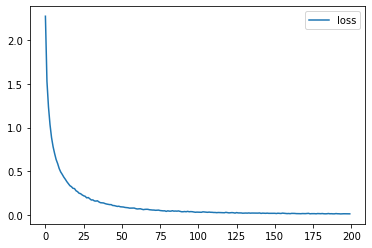

Train accuracy :  100.0 %
Test accuracy :  98.41 %
Confusion matrix 
 [[ 973    0    1    0    1    0    2    1    2    0]
 [   1 1122    3    2    0    1    2    1    3    0]
 [   5    1 1012    3    1    0    1    4    5    0]
 [   0    0    2  998    0    2    0    2    3    3]
 [   1    0    0    1  968    0    4    1    0    7]
 [   3    0    0    7    1  873    2    1    3    2]
 [   3    1    2    1    1    2  946    0    2    0]
 [   1    0    9    2    0    0    0 1009    2    5]
 [   2    0    2    2    2    4    0    3  956    3]
 [   3    2    0    6    6    3    0    5    0  984]]


In [28]:
# Plot losses
plot_losses(losses)

# Show accuracy
show_accuracies(model, train_data_loader, test_data_loader)

# Show confusion matrix
show_confusion_matrix(model, test_data_loader)

# Add batch normalization and dropout to model

In [30]:
# Design the model
class MLPBD(torch.nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLPBD, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=D_in, out_features=H1)
        self.normalization1 = torch.nn.BatchNorm1d(num_features=H1)
        self.dropout1 = torch.nn.Dropout(p=dropout_rate)
        self.activation1 = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(in_features=H1, out_features=H2)
        self.normalization2 = torch.nn.BatchNorm1d(num_features=H2)
        self.dropout2 = torch.nn.Dropout(p=dropout_rate)
        self.activation2 = torch.nn.Tanh()
        self.linear3= torch.nn.Linear(in_features=H2, out_features=D_out)
        
    def forward(self, x):
        self.h1 = self.linear1(x)
        self.n1 = self.normalization1(self.h1)
        self.d1 = self.dropout1(self.n1)
        self.a1 = self.activation1(self.d1)
        self.h2 = self.linear2(self.a1)
        self.n2 = self.normalization2(self.h2)
        self.d2 = self.dropout2(self.n2)
        self.a2 = self.activation2(self.d2)
        output = self.linear3(self.a2)
        return output

# Construct the model, loss, optimizer
model = MLPBD(D_in, H1, H2, D_out).to(dtype=dtype, device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model

In [31]:
losses = []

model.train()
initialize_parameters(model)

print("Training...")

for epoch in range(training_epochs):
    avg_loss = 0
    
    for data in train_data_loader:
        # Extract the data
        images, labels = data
        
        # Initialize optimizer
        optimizer.zero_grad()
        
        # Calculate model outputs and loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.item() / labels.size(0)
        
        # Calculate loss and update weights
        loss.backward()
        optimizer.step()
    
    losses.append(avg_loss)
    
    if (epoch + 1) % display_step == 0:
        print("epoch " + str(epoch + 1) + " : ", losses[-1])
    
print("Finsh training")

# Save the model parameters
torch.save(model.state_dict(), "mlp_with_batch_and_dropout.pt")

Training...
epoch 20 :  0.5664835464058909
epoch 40 :  0.2668550797045576
epoch 60 :  0.15400119155569
epoch 80 :  0.11162010037850774
epoch 100 :  0.07556336345935843
epoch 120 :  0.06170605945443893
epoch 140 :  0.04562012867327259
epoch 160 :  0.03946099257760861
epoch 180 :  0.03413876720599264
epoch 200 :  0.03268702155001269
Finsh training


# Train results

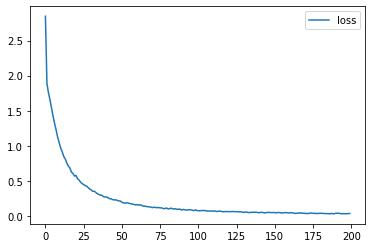

Train accuracy :  99.99666666666667 %
Test accuracy :  98.15 %
Confusion matrix 
 [[ 973    0    1    1    0    1    1    1    2    0]
 [   1 1123    3    0    0    0    3    1    4    0]
 [   4    1 1006    2    3    0    2    4    9    1]
 [   0    0    2  993    1    3    0    3    4    4]
 [   1    0    0    0  969    0    4    0    2    6]
 [   3    0    0    8    0  869    5    2    4    1]
 [   6    2    0    0    4    2  944    0    0    0]
 [   1    3    6    5    2    0    0 1004    3    4]
 [   6    0    0    1    5    1    2    3  955    1]
 [   5    2    0    4    9    0    0    4    6  979]]


In [32]:
# Plot losses
plot_losses(losses)

# Show accuracy
show_accuracies(model, train_data_loader, test_data_loader)

# Show confusion matrix
show_confusion_matrix(model, test_data_loader)